In [142]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [143]:
BLUE = "\033[94m"
RESET = "\033[0m"

In [144]:
video_data = pd.read_excel('data/EEG Video Timings.xlsx')
type_col_name = list(filter(lambda s: s.startswith('Type'), video_data.columns))[0]
generalized_sz = video_data[video_data[type_col_name] == 0]
fnames = 'data/videos/' + generalized_sz['Filename']+'.mp4'

In [145]:
generalized_sz['ID'].nunique()

30

In [146]:
import pickle
with open('data/df_time_find_best.pkl', 'rb') as f:
    df_time = pickle.load(f)

In [147]:
df_time['pt_id'].nunique()

30

In [148]:
df_time['vid_id'].nunique()

73

In [149]:
df_time.columns

Index(['R_axilla', 'L_axilla', 'R_elbow', 'L_elbow', 'R_ulnar_wrist',
       'L_ulnar_wrist', 'R_thumb', 'L_thumb', 'R_hip', 'L_hip',
       ...
       'a_Lower_mouth_2', 'a_Lower_mouth_3', 'a_Lower_mouth_4',
       'a_R_lateral_canthus', 'a_R_medial_canthus', 'a_L_lateral_canthus',
       'a_L_medial_canthus', 'a_R_eye_height', 'a_L_eye_height',
       'a_Mouth_height'],
      dtype='object', length=263)

#### Random Forest

In [150]:
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm.auto import tqdm

def train_evaluate_classifier(df_time):
    """
    Performs patient-level cross-validation with detailed progress tracking
    including patient IDs and video IDs
    """
    print("Starting classification pipeline...")

    classifiers = {}  # Dictionary to store classifier for each fold
    
    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(df_time['class'])
    
    # Get feature columns
    feature_cols = [col for col in df_time.columns 
                   if col not in ['class', 'pt_id', 'vid_id']]
    X = df_time[feature_cols]
    
    # Initialize GroupKFold for patient-level splitting
    n_splits = 5
    group_kfold = GroupKFold(n_splits=n_splits)
    
    # Initialize results storage
    results = {
        'fold': [], 'f1': [], 'auc': [], 
        'sensitivity': [], 'specificity': [],
        'tn': [], 'fp': [], 'fn': [], 'tp': []
    }
    
    # Store predictions
    predictions_df = pd.DataFrame()
    
    # Get unique patient and video IDs
    unique_pts = df_time['pt_id'].unique()
    total_videos = df_time['vid_id'].nunique()
    print(f"\nTotal patients: {len(unique_pts)}")
    print(f"Total videos: {total_videos}")
    fold_splits = list(group_kfold.split(unique_pts, groups=unique_pts))
    
    # Random Forest parameters
    rf_params = {
        'n_estimators': 500,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
        'random_state': 42,
        'n_jobs': -1,
        'class_weight': 'balanced',
        'verbose': 0
    }
    
    # Main fold loop with progress bar
    for fold, (train_pt_idx, val_pt_idx) in enumerate(tqdm(fold_splits, desc="Folds", unit="fold")):
        print(f"\nProcessing Fold {fold + 1}/{n_splits}")
        
        # Get patient IDs for this fold
        train_pts = unique_pts[train_pt_idx]
        val_pts = unique_pts[val_pt_idx]
        
        # Get video counts for this fold
        train_videos = df_time[df_time['pt_id'].isin(train_pts)]['vid_id'].nunique()
        val_videos = df_time[df_time['pt_id'].isin(val_pts)]['vid_id'].nunique()
        
        print("\nTraining Set:")
        print(f"Patients ({len(train_pts)}): {', '.join(map(str, train_pts))}")
        print(f"Videos: {train_videos}")
        
        print("\nValidation Set:")
        print(f"Patients ({len(val_pts)}): {', '.join(map(str, val_pts))}")
        print(f"Videos: {val_videos}")
        
        # Create train/val masks based on patient IDs
        train_mask = df_time['pt_id'].isin(train_pts)
        val_mask = df_time['pt_id'].isin(val_pts)
        
        # Split data
        X_train = X[train_mask]
        X_val = X[val_mask]
        y_train = y[train_mask]
        y_val = y[val_mask]
        
        print("\nTraining Random Forest...")
        clf = RandomForestClassifier(**rf_params)
        clf.fit(X_train, y_train)

        # Store the classifier
        classifiers[fold] = clf
        
        print("Making predictions...")
        # Process each validation patient separately
        for pt_id in tqdm(val_pts, desc="Validation Patients", unit="patient"):
            pt_mask = df_time['pt_id'] == pt_id
            pt_videos = df_time[pt_mask]['vid_id'].unique()
            
            for vid_id in tqdm(pt_videos, desc=f"Videos for Patient {pt_id}", unit="video", leave=False):
                vid_mask = (df_time['pt_id'] == pt_id) & (df_time['vid_id'] == vid_id)
                X_vid = X[vid_mask]
                y_vid = y[vid_mask]
                
                # Make predictions for this video
                y_pred_vid = clf.predict(X_vid)
                y_pred_proba_vid = clf.predict_proba(X_vid)[:, 1]
                
                # Store predictions for this video
                vid_predictions = pd.DataFrame({
                    'fold': fold,
                    'pt_id': pt_id,
                    'vid_id': vid_id,
                    'true_class': le.inverse_transform(y_vid),
                    'predicted_class': le.inverse_transform(y_pred_vid),
                    'prediction_probability': y_pred_proba_vid
                }, index=df_time[vid_mask].index)
                
                predictions_df = pd.concat([predictions_df, vid_predictions])
        
        # Calculate metrics for the entire fold
        y_pred = predictions_df[predictions_df['fold'] == fold]['predicted_class'].map({'nml': 0, 'sz': 1})
        y_true = predictions_df[predictions_df['fold'] == fold]['true_class'].map({'nml': 0, 'sz': 1})
        y_pred_proba = predictions_df[predictions_df['fold'] == fold]['prediction_probability']
        
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store metrics
        results['fold'].append(fold)
        results['f1'].append(f1)
        results['auc'].append(auc)
        results['sensitivity'].append(sensitivity)
        results['specificity'].append(specificity)
        results['tn'].append(tn) 
        results['fp'].append(fp) 
        results['fn'].append(fn)
        results['tp'].append(tp)
        
        # Print current fold metrics
        print(f"\nFold {fold + 1} Metrics:")
        print("\nConfusion Matrix:")
        print(f"[[{tn}, {fp}],")
        print(f" [{fn}, {tp}]]")
        print(f"F1 Score: {f1:.3f}")
        print(f"AUC: {auc:.3f}")
        print(f"Sensitivity: {sensitivity:.3f}")
        print(f"Specificity: {specificity:.3f}")
        print("*" * 80)
    
    # Sort by original index
    predictions_df = predictions_df.sort_index()
    
    # Calculate and print average metrics
    metrics_df = pd.DataFrame(results)
    print(f"\n{BLUE}Final Average Metrics:{RESET}")
    print(f"{BLUE}F1 Score: {metrics_df['f1'].mean():.3f} ± {metrics_df['f1'].std():.3f}{RESET}")
    print(f"{BLUE}AUC: {metrics_df['auc'].mean():.3f} ± {metrics_df['auc'].std():.3f}{RESET}")
    print(f"{BLUE}Sensitivity: {metrics_df['sensitivity'].mean():.3f} ± {metrics_df['sensitivity'].std():.3f}{RESET}")
    print(f"{BLUE}Specificity: {metrics_df['specificity'].mean():.3f} ± {metrics_df['specificity'].std():.3f}{RESET}")
    
    return metrics_df, predictions_df, classifiers

In [ ]:
metrics_df, predictions_df, classifiers = train_evaluate_classifier(df_time)

Starting classification pipeline...

Total patients: 30
Total videos: 73


Folds:   0%|          | 0/5 [00:00<?, ?fold/s]


Processing Fold 1/5

Training Set:
Patients (24): 5418761, 6394294, 5467817, 5271491, 5486196, 5514820, 5513119, 5447543, 2268547, 5454991, 5235825, 5352576, 2604950, 5512494, 6375932, 5489744, 6381028, 582992, 6338772, 5109836, 6431398, 5478774, 913367, 5023116
Videos: 58

Validation Set:
Patients (6): 6348578, 5323733, 2940398, 5497695, 5463487, 6452950
Videos: 15

Training Random Forest...
Making predictions...


Validation Patients:   0%|          | 0/6 [00:00<?, ?patient/s]

Videos for Patient 6348578:   0%|          | 0/3 [00:00<?, ?video/s]

Videos for Patient 5323733:   0%|          | 0/1 [00:00<?, ?video/s]

Videos for Patient 2940398:   0%|          | 0/5 [00:00<?, ?video/s]

Videos for Patient 5497695:   0%|          | 0/4 [00:00<?, ?video/s]

Videos for Patient 5463487:   0%|          | 0/1 [00:00<?, ?video/s]

Videos for Patient 6452950:   0%|          | 0/1 [00:00<?, ?video/s]


Fold 1 Metrics:

Confusion Matrix:
[[103641, 47859],
 [3193, 23113]]
F1 Score: 0.475
AUC: 0.860
Sensitivity: 0.879
Specificity: 0.684
********************************************************************************

Processing Fold 2/5

Training Set:
Patients (24): 6348578, 5418761, 6394294, 5323733, 5271491, 5486196, 5514820, 5513119, 5447543, 2940398, 2268547, 5454991, 5497695, 5463487, 5235825, 2604950, 5489744, 6381028, 582992, 6338772, 5109836, 6452950, 5478774, 913367
Videos: 59

Validation Set:
Patients (6): 5467817, 5352576, 5512494, 6375932, 6431398, 5023116
Videos: 14

Training Random Forest...
Making predictions...


Validation Patients:   0%|          | 0/6 [00:00<?, ?patient/s]

Videos for Patient 5467817:   0%|          | 0/1 [00:00<?, ?video/s]

Videos for Patient 5352576:   0%|          | 0/4 [00:00<?, ?video/s]

Videos for Patient 5512494:   0%|          | 0/1 [00:00<?, ?video/s]

Videos for Patient 6375932:   0%|          | 0/1 [00:00<?, ?video/s]

Videos for Patient 6431398:   0%|          | 0/2 [00:00<?, ?video/s]

Videos for Patient 5023116:   0%|          | 0/5 [00:00<?, ?video/s]


Fold 2 Metrics:

Confusion Matrix:
[[62062, 50258],
 [3642, 18685]]
F1 Score: 0.409
AUC: 0.694
Sensitivity: 0.837
Specificity: 0.553
********************************************************************************

Processing Fold 3/5

Training Set:
Patients (24): 6348578, 6394294, 5467817, 5323733, 5271491, 5486196, 5514820, 5447543, 2940398, 2268547, 5454991, 5497695, 5463487, 5235825, 5352576, 2604950, 5512494, 6375932, 5489744, 582992, 6338772, 6452950, 6431398, 5023116
Videos: 51

Validation Set:
Patients (6): 5418761, 5513119, 6381028, 5109836, 5478774, 913367
Videos: 22

Training Random Forest...
Making predictions...


Validation Patients:   0%|          | 0/6 [00:00<?, ?patient/s]

Videos for Patient 5418761:   0%|          | 0/2 [00:00<?, ?video/s]

Videos for Patient 5513119:   0%|          | 0/2 [00:00<?, ?video/s]

Videos for Patient 6381028:   0%|          | 0/7 [00:00<?, ?video/s]

Videos for Patient 5109836:   0%|          | 0/5 [00:00<?, ?video/s]

Videos for Patient 5478774:   0%|          | 0/2 [00:00<?, ?video/s]

Videos for Patient 913367:   0%|          | 0/4 [00:00<?, ?video/s]


Fold 3 Metrics:

Confusion Matrix:
[[152133, 21537],
 [12406, 32923]]
F1 Score: 0.660
AUC: 0.885
Sensitivity: 0.726
Specificity: 0.876
********************************************************************************

Processing Fold 4/5

Training Set:
Patients (24): 6348578, 5418761, 5467817, 5323733, 5271491, 5513119, 2940398, 5454991, 5497695, 5463487, 5352576, 2604950, 5512494, 6375932, 5489744, 6381028, 582992, 6338772, 5109836, 6452950, 6431398, 5478774, 913367, 5023116
Videos: 60

Validation Set:
Patients (6): 6394294, 5486196, 5514820, 5447543, 2268547, 5235825
Videos: 13

Training Random Forest...


In [121]:
metrics_df.to_csv("data/fold_metrics_RF_150_300_without_detection.csv", index=False)

In [48]:
predictions_df

,fold,pt_id,vid_id,true_class,predicted_class,prediction_probability
0,0,6348578,7942GT00,nml,nml,0.374125
0,3,5486196,7941M700,nml,nml,0.291587
0,4,582992,7952GQ00,nml,nml,0.488261
0,4,2604950,7950J900,nml,nml,0.246903
0,4,6338772,7972OT00,nml,nml,0.209989
...,...,...,...,...,...,...
24150,0,6348578,7942GZ00,sz,sz,0.651555
24151,0,6348578,7942GZ00,sz,sz,0.626503
24152,0,6348578,7942GZ00,sz,sz,0.619228
24153,0,6348578,7942GZ00,sz,sz,0.613609


In [49]:
predictions_df.to_pickle("data/predictions_150_300_without_detection.pkl")

In [14]:
raise Exception()

Exception: 

#### Video Level AUC

In [50]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_video_auc(df):
    """
    Calculate AUC for each unique video ID in the dataset.
    Returns a DataFrame with video-level AUC scores.
    """
    # Initialize storage for results
    video_metrics = []
    
    # Get unique video IDs
    unique_videos = df[['pt_id', 'vid_id']].drop_duplicates()
    
    for _, row in unique_videos.iterrows():
        pt_id = row['pt_id']
        vid_id = row['vid_id']
        
        # Get data for this video
        video_data = df[(df['pt_id'] == pt_id) & (df['vid_id'] == vid_id)]
        
        # Convert classes to binary
        y_true = (video_data['true_class'] == 'sz').astype(int)
        
        # Get prediction probabilities
        y_pred = video_data['prediction_probability']
        
        try:
            # Calculate AUC if we have both classes
            if len(np.unique(y_true)) > 1:
                auc = roc_auc_score(y_true, y_pred)
            else:
                auc = np.nan  # Can't calculate AUC with only one class
                
            video_metrics.append({
                'pt_id': pt_id,
                'vid_id': vid_id,
                'auc': auc,
                'n_samples': len(video_data),
                'n_seizure': sum(y_true),
                'n_normal': sum(y_true == 0),
                'calculable': len(np.unique(y_true)) > 1
            })
            
        except Exception as e:
            print(f"Error calculating AUC for video {vid_id} (patient {pt_id}): {str(e)}")
            
    # Create DataFrame with results
    results_df = pd.DataFrame(video_metrics)
    
    # Add some summary statistics
    print("\nSummary of video-level AUC scores:")
    print(f"Total videos: {len(results_df)}")
    print(f"Videos with calculable AUC: {sum(results_df['calculable'])}")
    calculable_aucs = results_df[results_df['calculable']]['auc']
    if len(calculable_aucs) > 0:
        print(f"Mean AUC: {calculable_aucs.mean():.3f} ± {calculable_aucs.std():.3f}")
        print(f"Median AUC: {calculable_aucs.median():.3f}")
        print(f"Min AUC: {calculable_aucs.min():.3f}")
        print(f"Max AUC: {calculable_aucs.max():.3f}")
    
    return results_df
video_auc = calculate_video_auc(predictions_df)
video_auc.sort_values('auc', ascending=False)


Summary of video-level AUC scores:
Total videos: 73
Videos with calculable AUC: 72
Mean AUC: 0.787 ± 0.247
Median AUC: 0.898
Min AUC: 0.095
Max AUC: 0.999


,pt_id,vid_id,auc,n_samples,n_seizure,n_normal,calculable
41,6394294,7942QQ00,0.998783,12707,2207,10500,True
61,6394294,7942QR00,0.998116,13336,2386,10950,True
67,5497695,7971C500,0.995312,7552,2062,5490,True
10,6381028,7953A300,0.994479,10500,1800,8700,True
69,5447543,7941D300,0.985871,6623,923,5700,True
...,...,...,...,...,...,...,...
16,5512494,7971H000,0.280283,4195,1285,2910,True
31,5023116,7963TA00,0.137398,11238,1938,9300,True
21,2940398,79611N00,0.130366,8541,1311,7230,True
55,2940398,79611Q00,0.095026,11088,2088,9000,True


In [44]:
video_auc.sort_values('auc', ascending=False).to_csv("data/auc_videos_RF_150_300_without_detection.csv", index=False)

#### Patient level AUC

In [51]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_patient_auc(df):
    """
    Calculate AUC for each unique patient ID in the dataset.
    Returns a DataFrame with patient-level AUC scores.
    """
    # Initialize storage for results
    patient_metrics = []
    
    # Get unique patient IDs
    unique_patients = df['pt_id'].unique()
    
    for pt_id in unique_patients:
        # Get all data for this patient
        patient_data = df[df['pt_id'] == pt_id]
        
        # Convert classes to binary
        y_true = (patient_data['true_class'] == 'sz').astype(int)
        
        # Get prediction probabilities
        y_pred = patient_data['prediction_probability']
        
        try:
            # Calculate AUC if we have both classes
            if len(np.unique(y_true)) > 1:
                auc = roc_auc_score(y_true, y_pred)
            else:
                auc = np.nan  # Can't calculate AUC with only one class
                
            patient_metrics.append({
                'pt_id': pt_id,
                'auc': auc,
                'n_samples': len(patient_data),
                'n_videos': patient_data['vid_id'].nunique(),
                'n_seizure': sum(y_true),
                'n_normal': sum(y_true == 0),
                'calculable': len(np.unique(y_true)) > 1
            })
            
        except Exception as e:
            print(f"Error calculating AUC for patient {pt_id}: {str(e)}")
            
    # Create DataFrame with results
    results_df = pd.DataFrame(patient_metrics)
    
    # Add some summary statistics
    print("\nSummary of patient-level AUC scores:")
    print(f"Total patients: {len(results_df)}")
    print(f"Patients with calculable AUC: {sum(results_df['calculable'])}")
    calculable_aucs = results_df[results_df['calculable']]['auc']
    if len(calculable_aucs) > 0:
        print(f"Mean AUC: {calculable_aucs.mean():.3f} ± {calculable_aucs.std():.3f}")
        print(f"Median AUC: {calculable_aucs.median():.3f}")
        print(f"Min AUC: {calculable_aucs.min():.3f}")
        print(f"Max AUC: {calculable_aucs.max():.3f}")
    
    return results_df

# Use it like this:
patient_auc = calculate_patient_auc(predictions_df)
patient_auc.sort_values('auc', ascending=False)


Summary of patient-level AUC scores:
Total patients: 30
Patients with calculable AUC: 30
Mean AUC: 0.767 ± 0.226
Median AUC: 0.862
Min AUC: 0.280
Max AUC: 0.989


,pt_id,auc,n_samples,n_videos,n_seizure,n_normal,calculable
21,6394294,0.988672,33026,3,7256,25770,True
1,5486196,0.985621,7642,1,2332,5310,True
27,5235825,0.982627,3896,1,1946,1950,True
4,6338772,0.974315,14100,1,1950,12150,True
25,5454991,0.955938,12737,1,1937,10800,True
26,5513119,0.948251,17231,2,4211,13020,True
23,5497695,0.938901,37221,4,8271,28950,True
15,5323733,0.932307,21578,1,1688,19890,True
17,5352576,0.908802,27421,4,9001,18420,True
19,5489744,0.907411,22926,2,6666,16260,True


In [46]:
patient_auc.sort_values('auc', ascending=False).to_csv("data/auc_patients_RF_150_300_without_detection.csv", index = False)

#### Plots

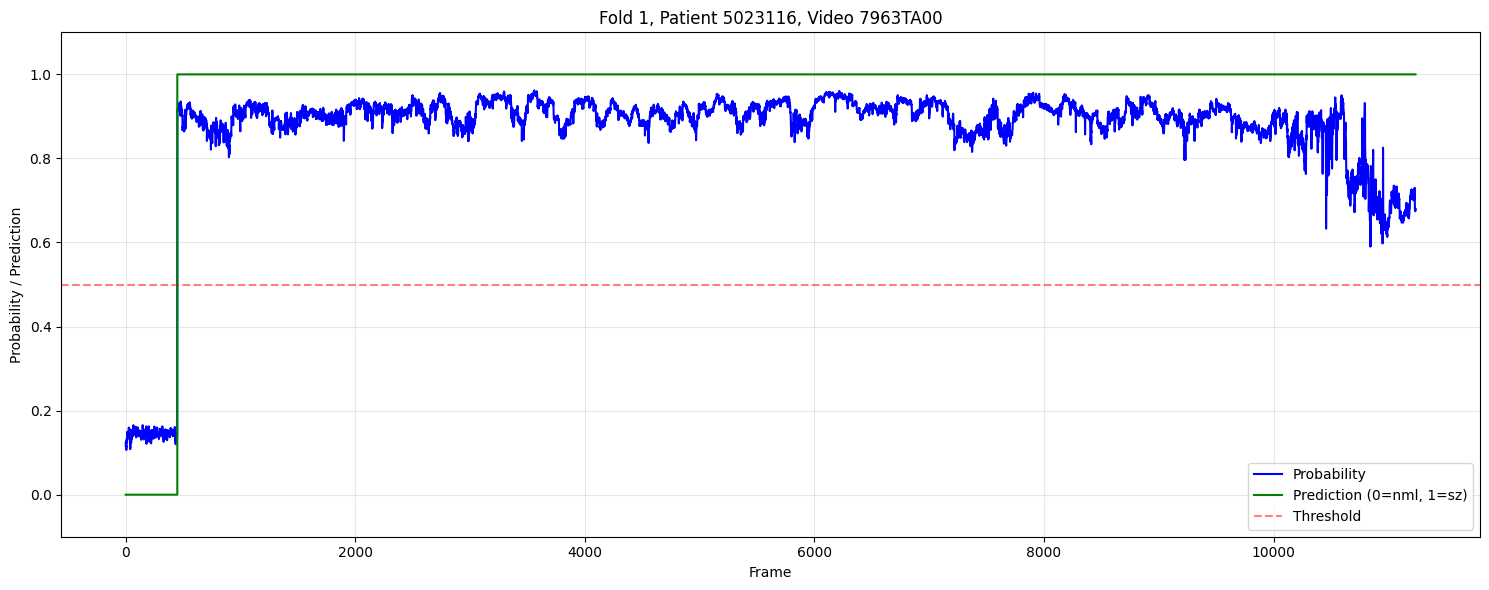

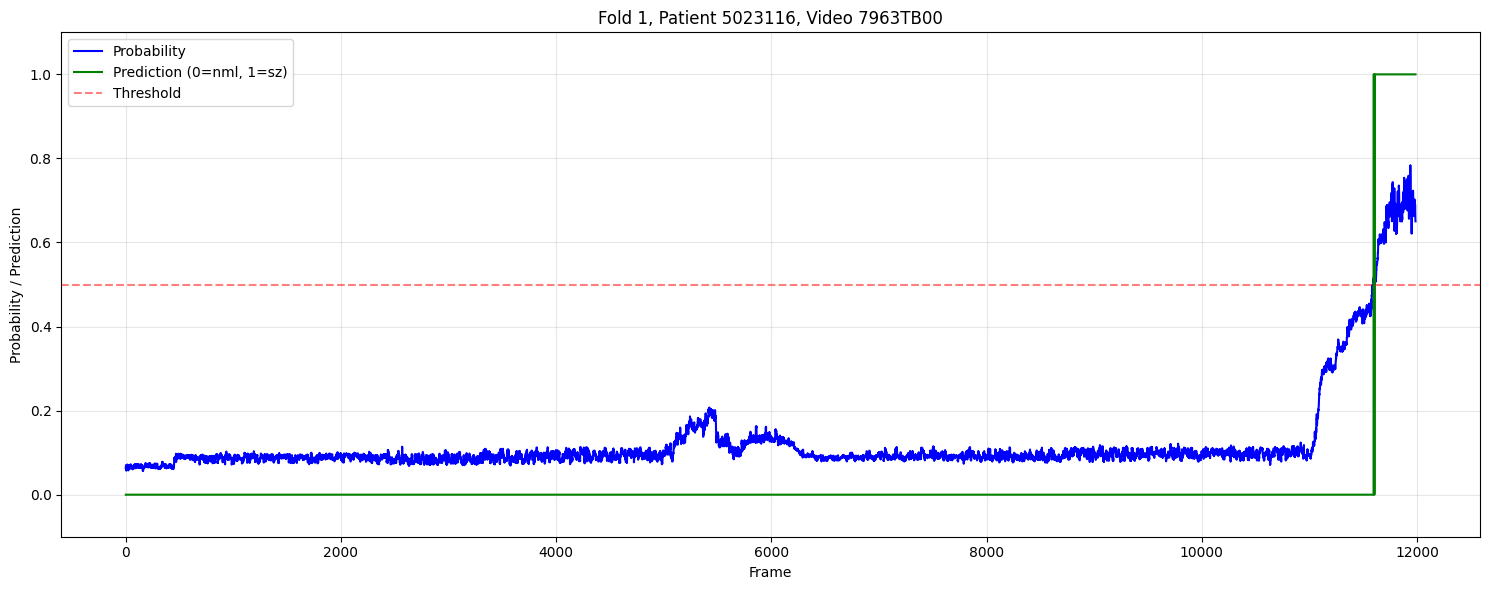

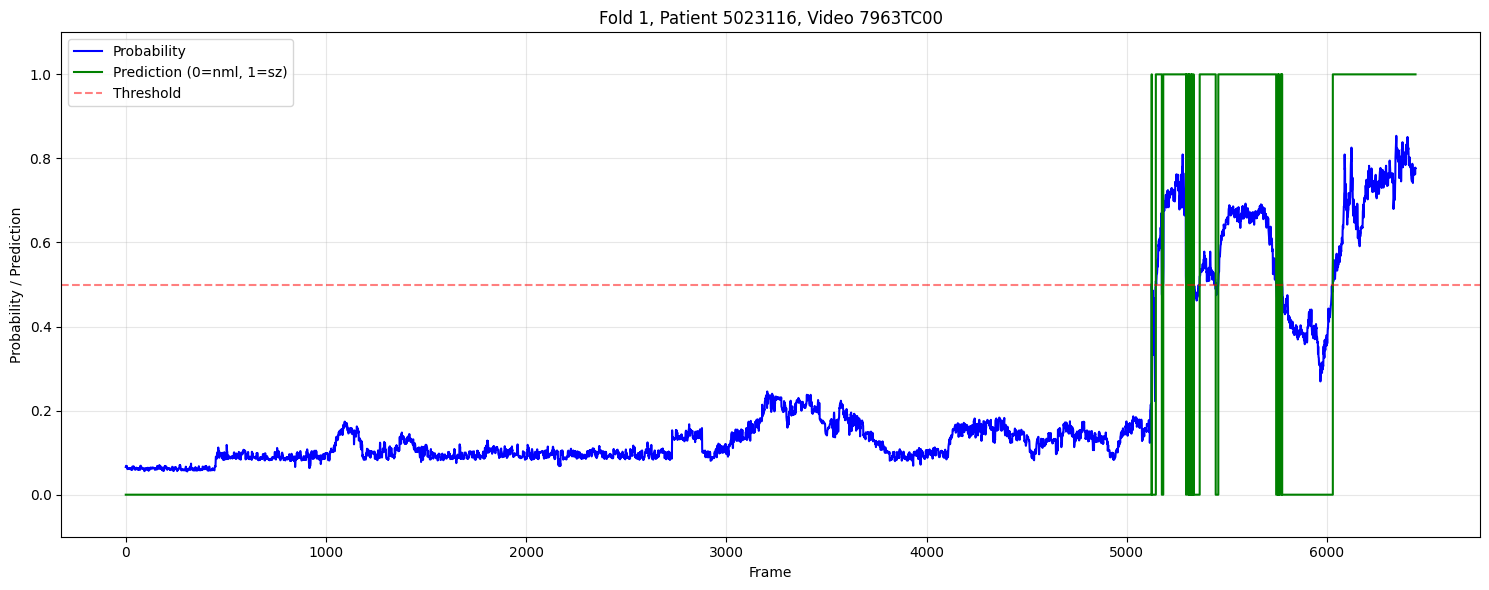

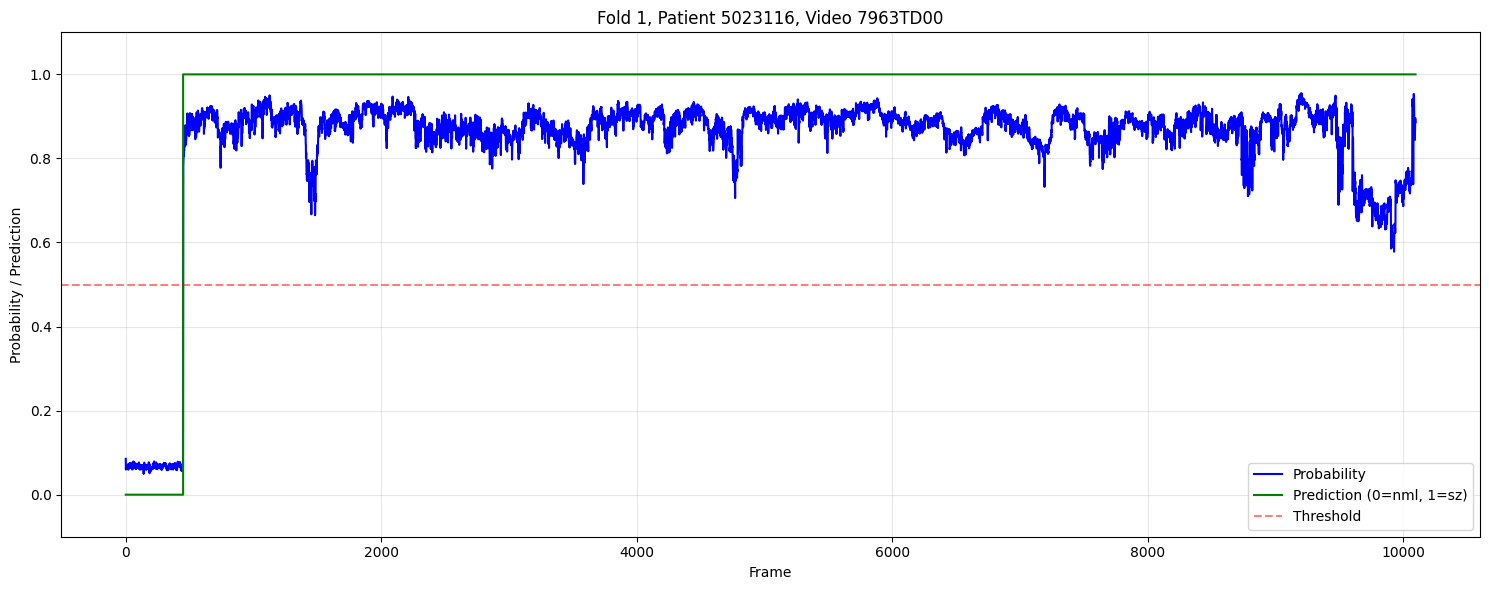

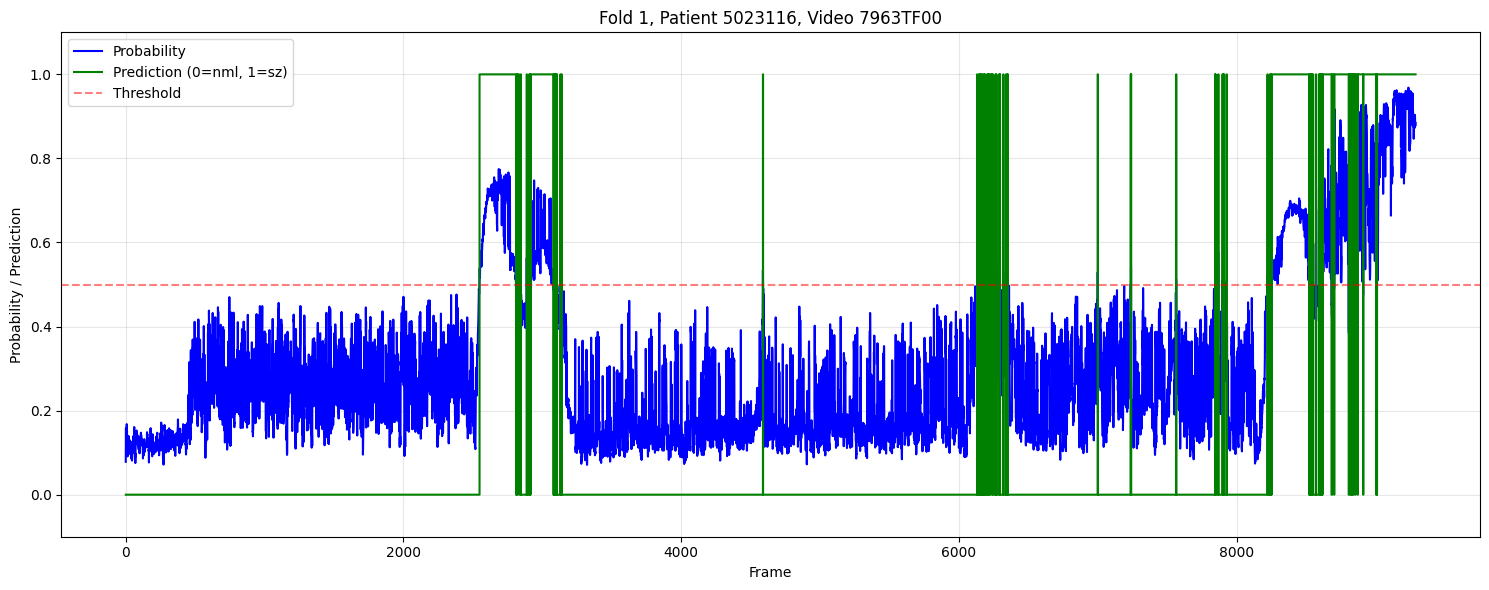

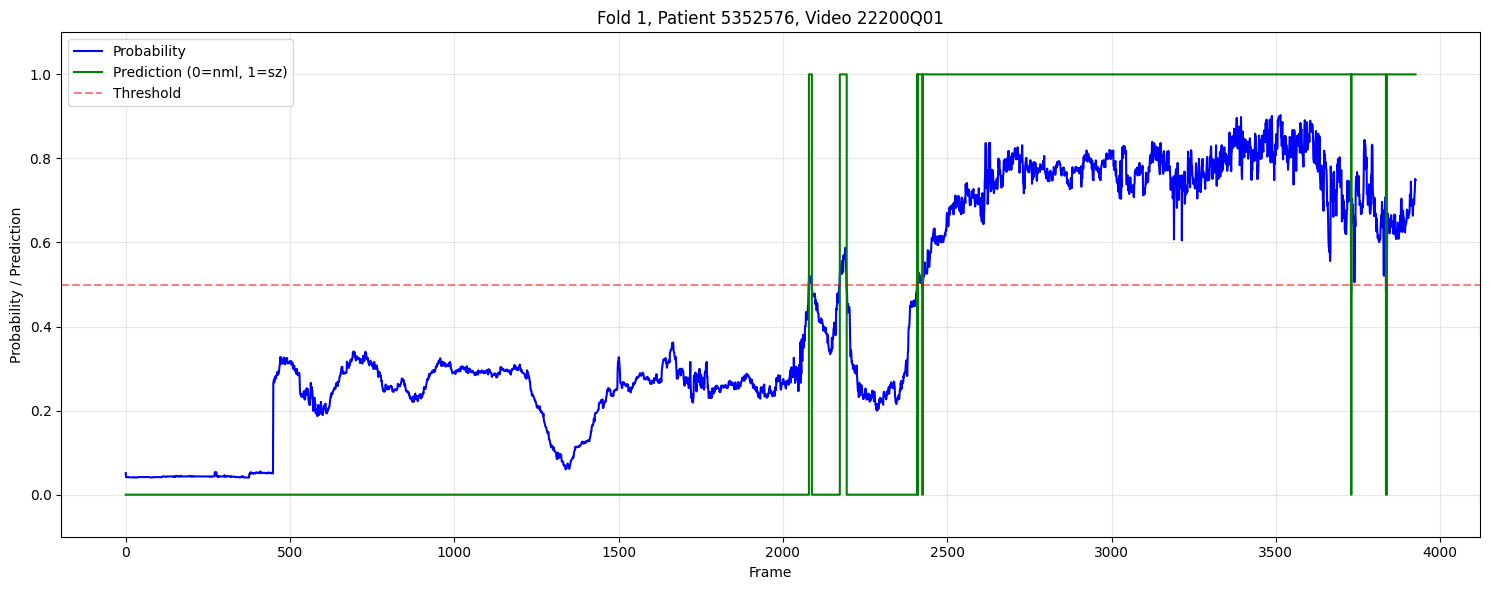

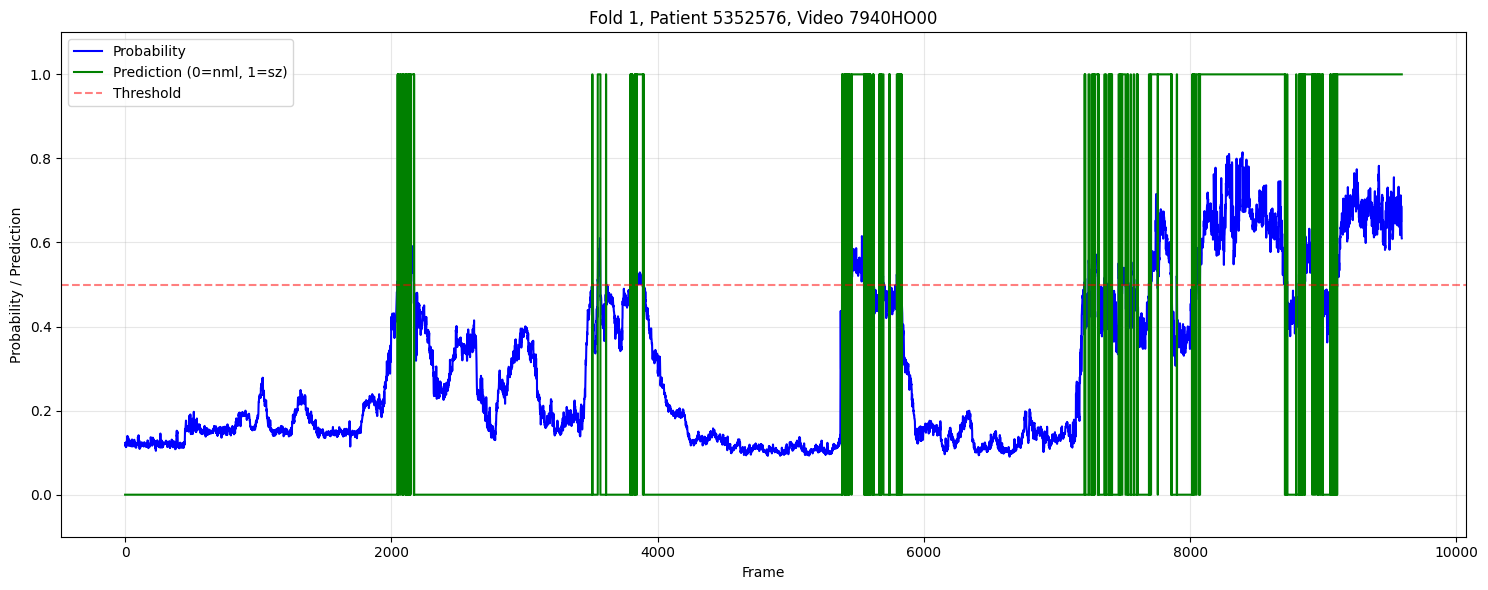

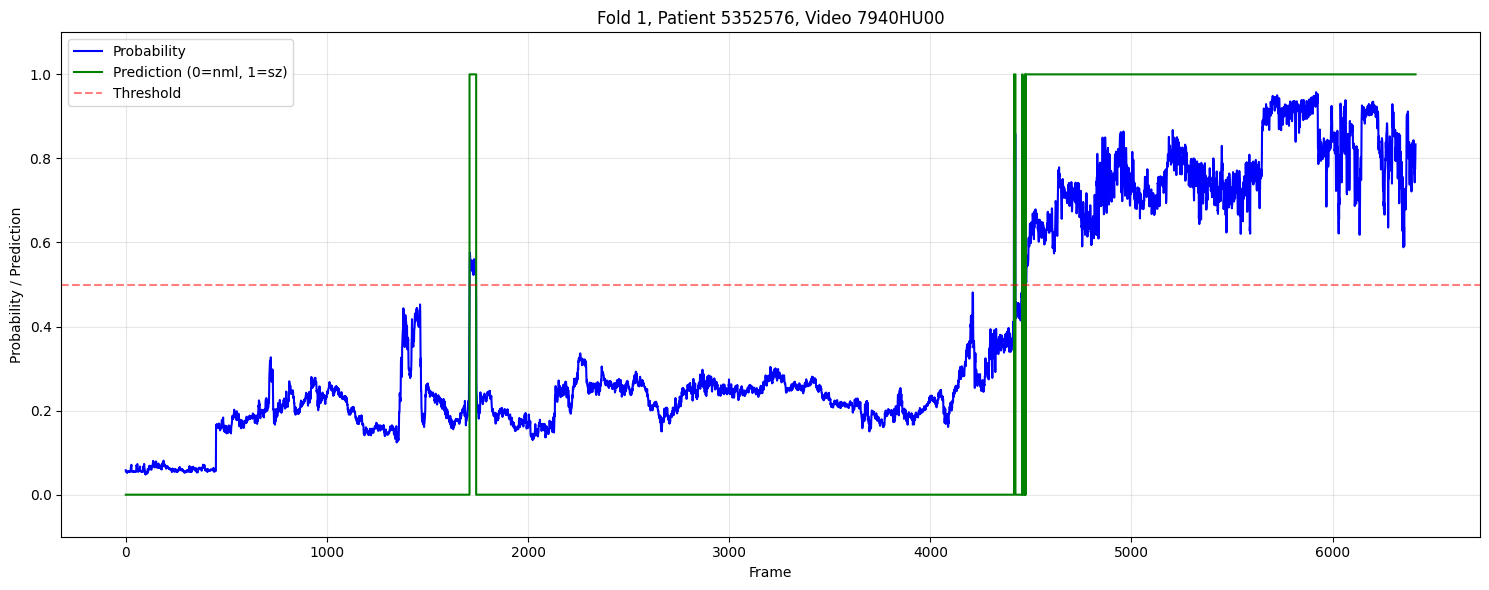

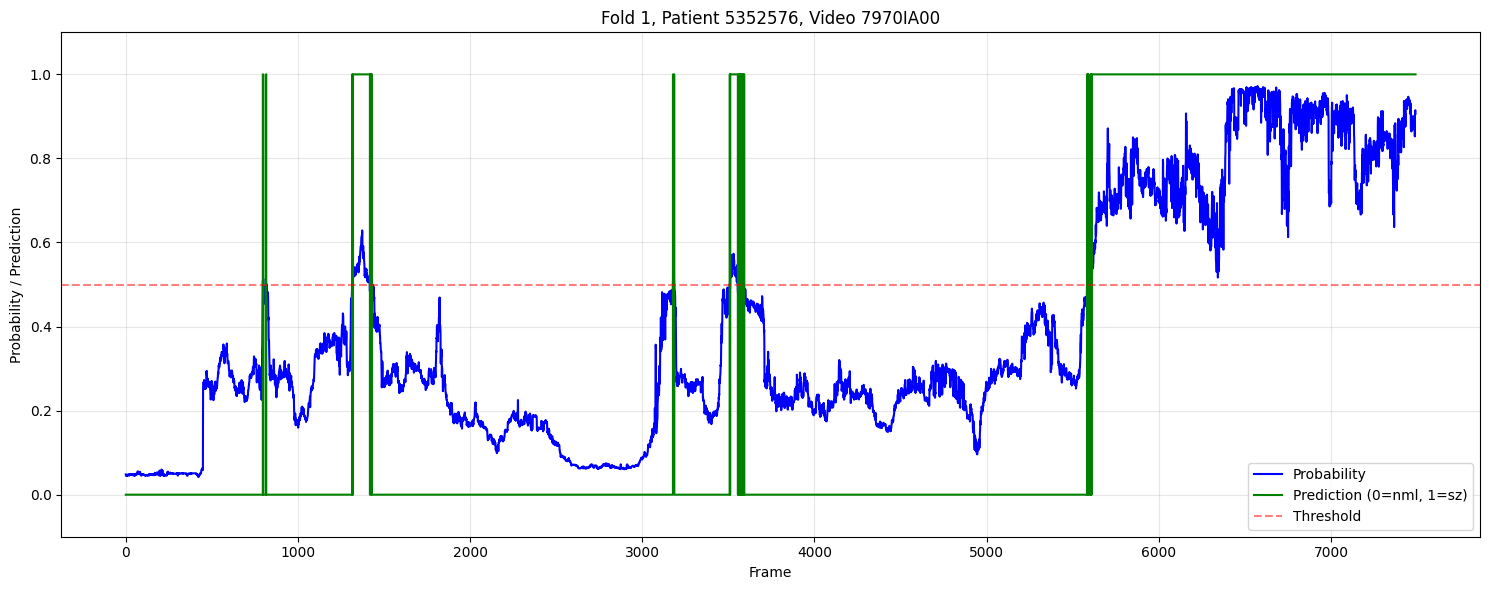

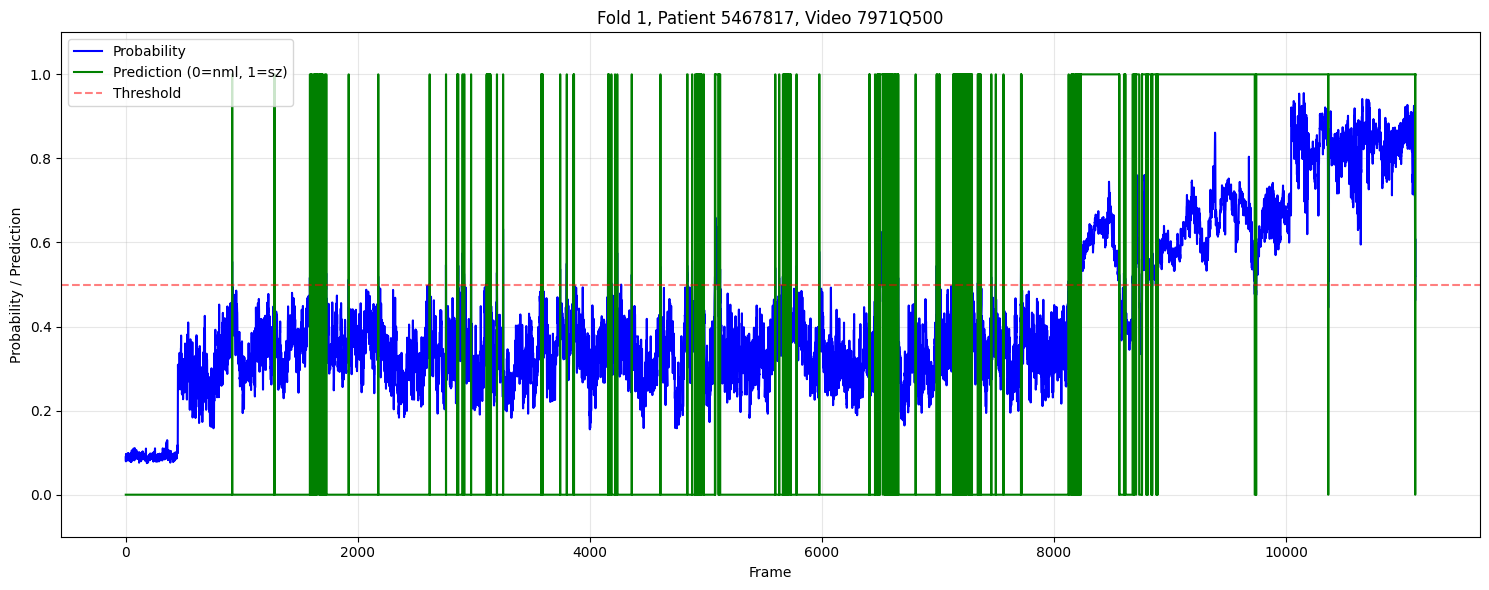

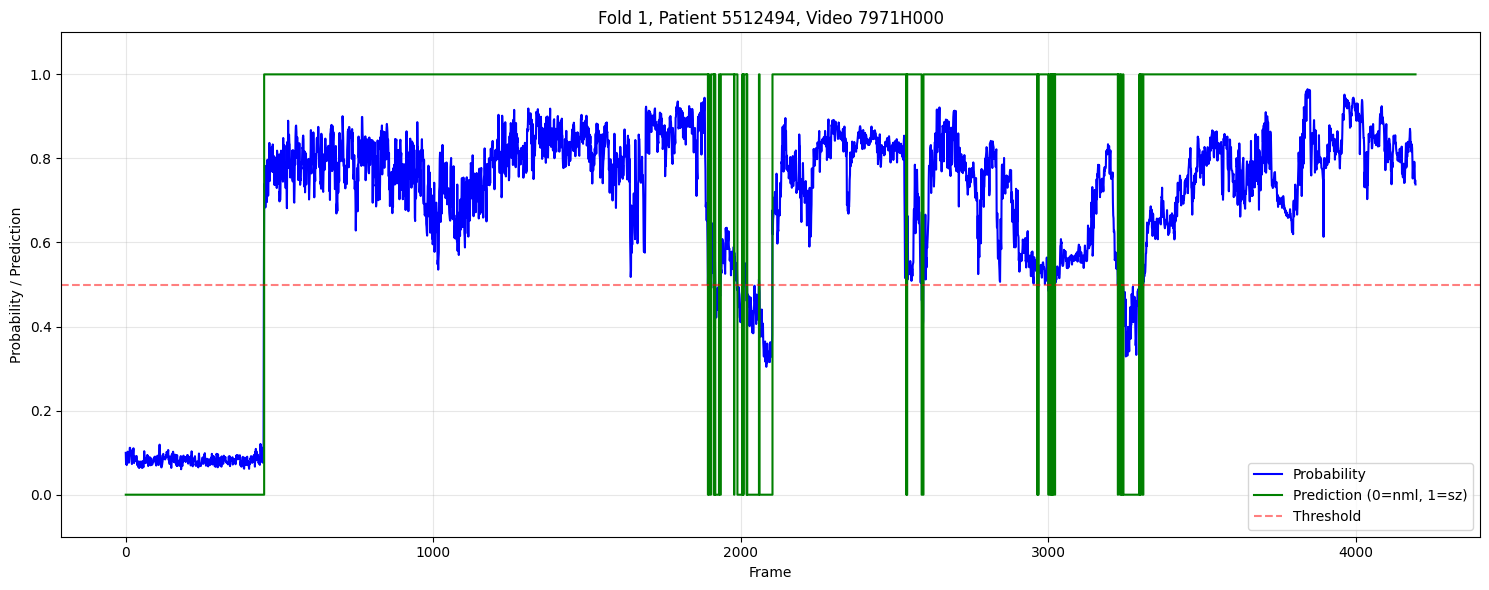

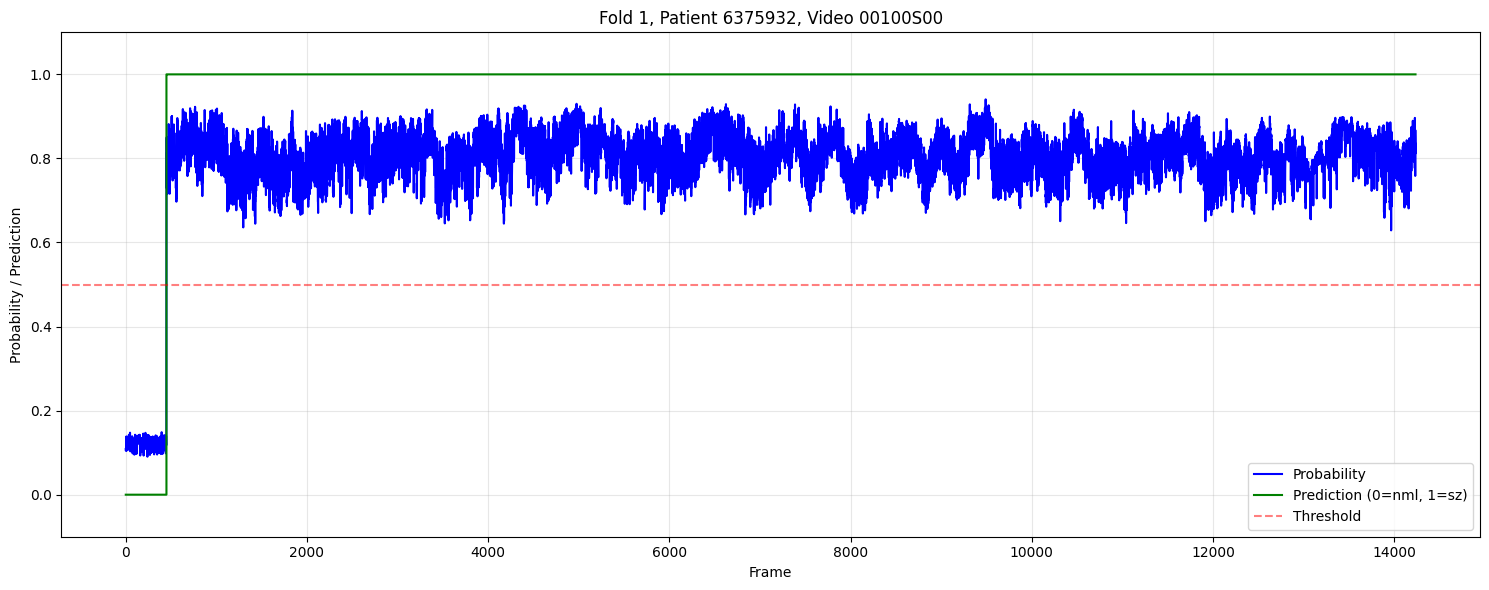

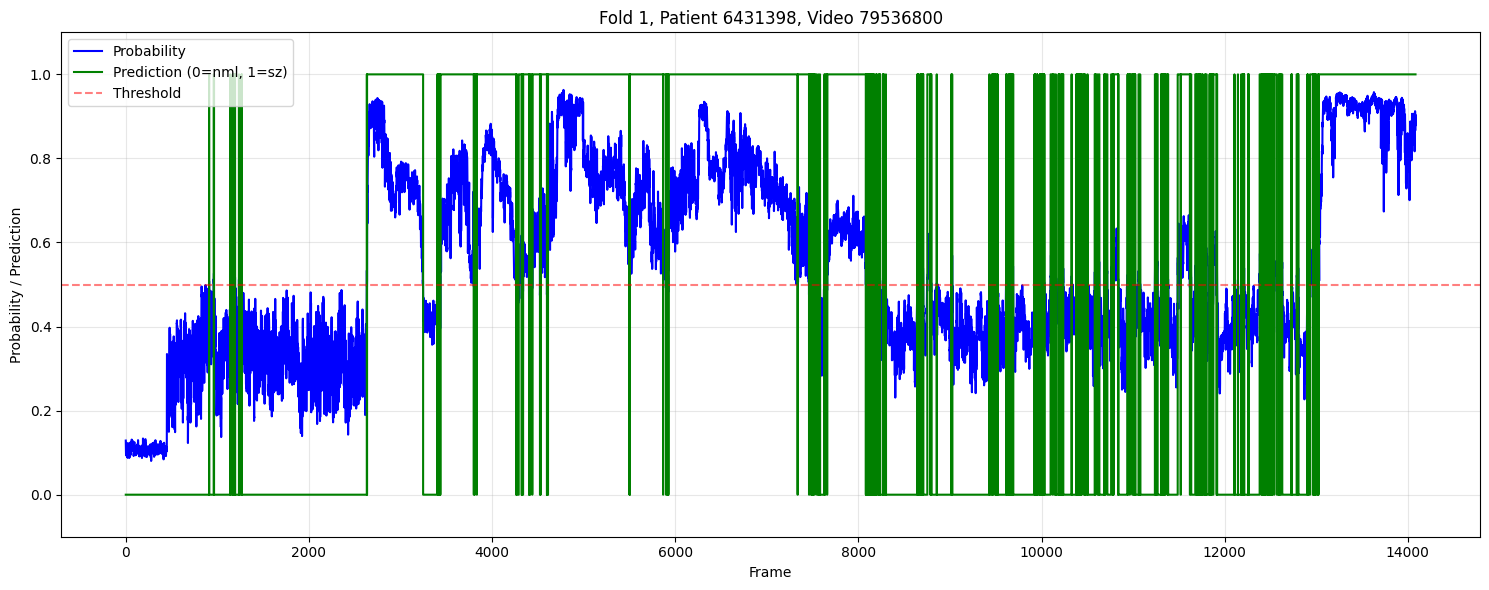

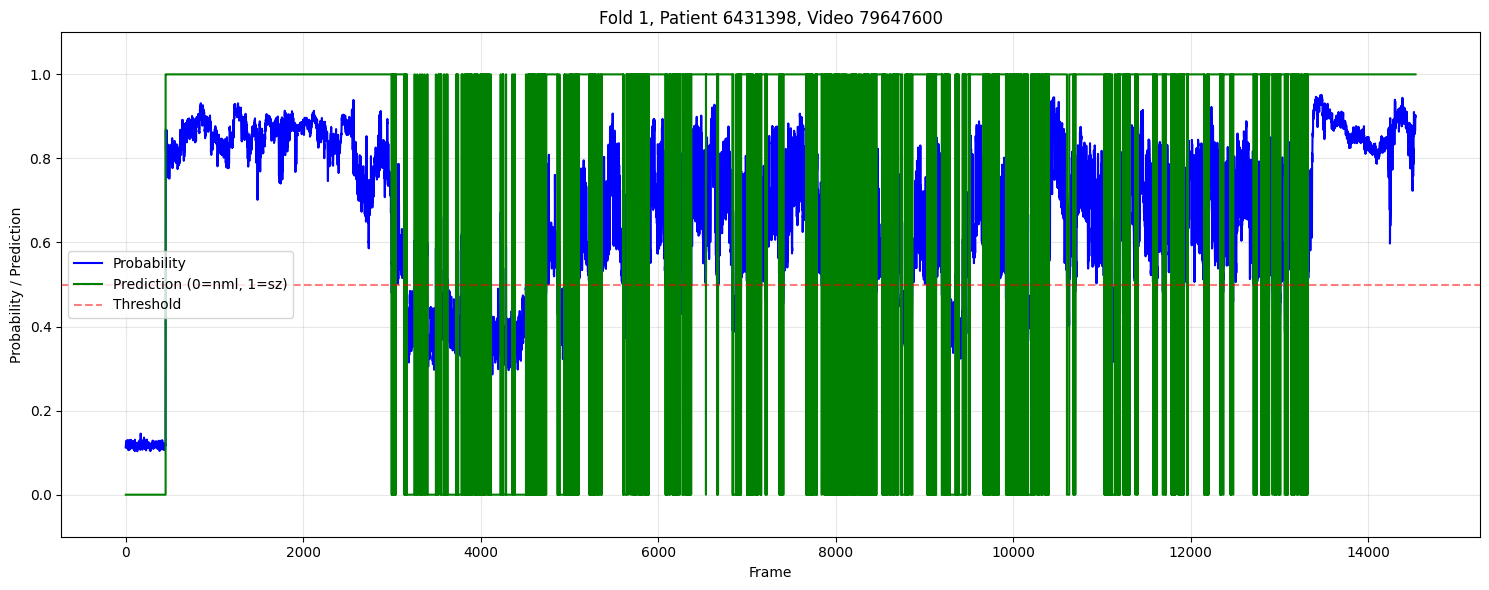

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_predictions(predictions_df, fold=None, patient_id=None, figsize=(15, 6)):
    """
    Plot predictions and probabilities for videos, filtered by fold and/or patient_id.
    
    Parameters:
    predictions_df: DataFrame with predictions
    fold: specific fold to plot (optional)
    patient_id: specific patient to plot (optional)
    figsize: tuple for figure size
    """
    # Filter data if fold or patient_id specified
    plot_df = predictions_df.copy()
    if fold is not None:
        plot_df = plot_df[plot_df['fold'] == fold]
    if patient_id is not None:
        plot_df = plot_df[plot_df['pt_id'] == patient_id]
    
    # Get unique combinations of fold, patient, and video
    combinations = plot_df.groupby(['fold', 'pt_id', 'vid_id']).size().reset_index()
    
    # Plot each video
    for _, row in combinations.iterrows():
        fold_num, pt_id, vid_id = row['fold'], row['pt_id'], row['vid_id']
        
        # Filter data for this video
        video_data = plot_df[
            (plot_df['fold'] == fold_num) & 
            (plot_df['pt_id'] == pt_id) & 
            (plot_df['vid_id'] == vid_id)
        ].copy()
        
        # Reset index to get frame numbers if not already present
        if 'frame' not in video_data.columns:
            video_data = video_data.reset_index()
            video_data = video_data.rename(columns={'index': 'frame'})
        
        # Create figure
        plt.figure(figsize=figsize)
        
        # Plot probability
        sns.lineplot(data=video_data, x='frame', y='prediction_probability', 
                    color='blue', label='Probability')
        
        # Plot binary predictions (convert to 0/1)
        binary_preds = (video_data['predicted_class'] == 'sz').astype(int)
        sns.lineplot(data=video_data, x='frame', y=binary_preds, 
                    color='green', drawstyle='steps-post', label='Prediction (0=nml, 1=sz)')
        
        # Add reference line at 0.5
        plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')
        
        # Customize plot
        plt.title(f'Fold {fold_num}, Patient {pt_id}, Video {vid_id}')
        plt.xlabel('Frame')
        plt.ylabel('Probability / Prediction')
        plt.ylim(-0.1, 1.1)  # Add some padding to y-axis
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Show plot
        plt.tight_layout()
        plt.show()

def plot_all_predictions(predictions_df):
    """
    Plot all predictions organized by fold and patient
    """
    # Get unique folds
    folds = sorted(predictions_df['fold'].unique())
    
    print("Starting visualization...")
    
    # Plot for each fold
    for fold in folds:
        print(f"\nProcessing Fold {fold}")
        
        # Get unique patients in this fold
        patients = sorted(predictions_df[predictions_df['fold'] == fold]['pt_id'].unique())
        
        for pt_id in patients:
            print(f"Processing Patient {pt_id}")
            plot_predictions(predictions_df, fold=fold, patient_id=pt_id)
            
    print("\nVisualization complete!")

# Example usage:
# For specific fold and patient:
#plot_predictions(predictions_df, fold=0, patient_id=1)

# For all predictions:
# plot_all_predictions(predictions_df)

# For all videos of a specific patient across folds:
# plot_predictions(predictions_df, patient_id=1)

# For all videos in a specific fold:
plot_predictions(predictions_df, fold=1)

#### feature importance

In [52]:
import seaborn as sns
def plot_feature_importance(clf, feature_names, top_n=10, figsize=(10, 6)):
    """
    Plot top N feature importances from the Random Forest classifier.
    
    Parameters:
    clf: Trained RandomForestClassifier
    feature_names: List of feature names
    top_n: Number of top features to show (default=10)
    figsize: Figure size tuple (default=(10,6))
    """
    # Get feature importances and names
    importances = clf.feature_importances_
    
    # Create DataFrame with feature names and importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance and get top N
    importance_df = importance_df.sort_values('Importance', ascending=False).head(top_n)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot horizontal bar chart
    sns.barplot(data=importance_df, 
                y='Feature', 
                x='Importance',
                palette='viridis')
    
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Return the importance DataFrame
    return importance_df

# Example usage:
# Assuming you have feature names and trained classifier:
#feature_names = [col for col in df_time.columns if col not in ['class', 'pt_id', 'vid_id']]
#importance_df = plot_feature_importance(clf, feature_names)
# 
# Print exact values:
# print("\nFeature Importance Values:")
# print(importance_df.to_string(index=False))

In [53]:
'''# Plot feature importance for each fold
for fold, clf in classifiers.items():
    print(f"\nFeature Importances for Fold {fold}")
    importance_df = plot_feature_importance(clf, feature_names)
    print("\nTop 10 Features and their Importance Values:")
    print(importance_df.to_string(index=False))'''

'# Plot feature importance for each fold\nfor fold, clf in classifiers.items():\n    print(f"\nFeature Importances for Fold {fold}")\n    importance_df = plot_feature_importance(clf, feature_names)\n    print("\nTop 10 Features and their Importance Values:")\n    print(importance_df.to_string(index=False))'


Average Feature Importances Across All Folds:


/tmp/ipykernel_37/831278539.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df,


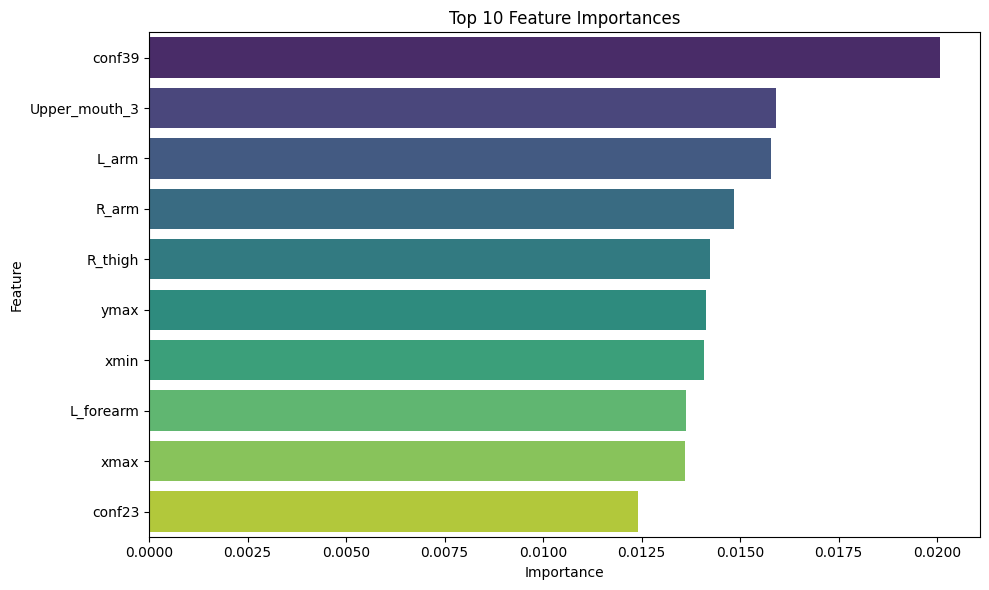


Top 10 Features and their Average Importance Values:
      Feature  Importance
       conf39    0.020088
Upper_mouth_3    0.015902
        L_arm    0.015784
        R_arm    0.014859
      R_thigh    0.014241
         ymax    0.014140
         xmin    0.014085
    L_forearm    0.013621
         xmax    0.013600
       conf23    0.012405


In [54]:
# Calculate average feature importance across folds
feature_names = [col for col in df_time.columns if col not in ['class', 'pt_id', 'vid_id']]
avg_importances = np.zeros(len(feature_names))
for clf in classifiers.values():
    avg_importances += clf.feature_importances_

avg_importances /= len(classifiers)

# Create temporary classifier object to hold average importances
temp_clf = type('obj', (), {'feature_importances_': avg_importances})

print("\nAverage Feature Importances Across All Folds:")
importance_df = plot_feature_importance(temp_clf, feature_names)
print("\nTop 10 Features and their Average Importance Values:")
print(importance_df.to_string(index=False))

#### Process videos with predictions

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def overlay_predictions_on_video(video_path, predictions, probabilities, start_frame, output_path, max_frame=None):
    """
    Overlay progressive seizure prediction probabilities graph onto the video.
    
    Args:
        video_path (str): Path to input video file
        predictions (np.array): Predicted classes for each frame
        probabilities (np.array): Prediction probabilities for each frame
        start_frame (int): Frame number where seizure starts
        output_path (str): Path to save output video
        max_frame (int, optional): Maximum number of frames to process. If None, process all frames.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    print(f"Overlaying predictions on video {video_path}")
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Limit frames if max_frame is set
    if max_frame is not None:
        total_frames = min(total_frames, max_frame)
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Prepare probability plot
    plt.figure(figsize=(width / 100, height / 2.5 / 100), dpi=100)  # Make the graph taller
    plt.style.use('dark_background')  # Dark background for better contrast
    
    # Process each frame
    frame_count = 0
    while cap.isOpened() and (max_frame is None or frame_count < max_frame):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Clear previous plot
        plt.clf()
        
        # Plot probabilities up to current frame
        probs = probabilities[:, 1] if len(probabilities.shape) > 1 else probabilities
        
        # Determine the range of frames to plot
        plot_start = 0
        #plot_end = frame_count + 1
        plot_end = min(frame_count + 1, len(probs))

        
        # Plot probabilities
        plt.plot(range(plot_start, plot_end), probs[plot_start:plot_end], color='black', linewidth=2, label='Probability')
        
        # Styling the graph
        plt.xlim(plot_start, total_frames)
        plt.ylim(0, 1)
        plt.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Threshold (0.5)')  # Add threshold line
        plt.title(f'Seizure Probability (Frame {frame_count})')
        plt.xlabel('Frames')
        plt.ylabel('Probability')
        
        # Highlight seizure start frame
        plt.axvline(x=start_frame, color='green', linestyle='--', linewidth=2, label='Seizure Start')
        #plt.legend(loc='upper right')
        
        # Make plot background transparent
        plt.gcf().patch.set_alpha(0)
        plt.gca().patch.set_alpha(0)
        
        # Render graph to image
        plt.tight_layout()
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        
        # Convert plot to image
        graph_image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        #graph_image = graph_image.reshape(canvas.get_width_height()[::-1] + (3,))
        graph_image = graph_image.reshape(canvas.get_width_height()[::-1] + (4,))  # RGBA

        # Remove the alpha channel to use RGB
        graph_image = graph_image[:, :, :3]
        
        # Resize graph to fit video width
        graph_image = cv2.resize(graph_image, (width, int(height / 2.5)))
        
        # Create a semi-transparent overlay
        overlay = frame.copy()
        overlay[height - graph_image.shape[0]:height, :] = graph_image
        
        # Blend the overlay
        frame = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)
        
        # Add probability text
        '''if frame_count < len(probs):
            prob = probs[frame_count]
            text = f"Seizure Prob: {prob:.2f}"
            cv2.putText(frame, text, (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            
            # Highlight seizure start frame
            if frame_count == start_frame:
                cv2.rectangle(frame, (0, 0), (width, height), (0, 255, 0), 10)
                cv2.putText(frame, "SEIZURE STARTS", (width // 2 - 200, height - 50), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)'''
        
        # Write the frame
        out.write(frame)
        frame_count += 1
    
    # Release resources
    plt.close()
    cap.release()
    out.release()


In [17]:
predictions_df.groupby(["fold", "pt_id", "vid_id"]).size().reset_index()[["fold", "pt_id", "vid_id"]]

,fold,pt_id,vid_id
0,0,2940398,79611N00
1,0,2940398,79611Q00
2,0,2940398,79611T00
3,0,2940398,79611U00
4,0,2940398,79612000
...,...,...,...
68,4,5271491,7941OZ00
69,4,5454991,79410R00
70,4,5489744,7941CO00
71,4,5489744,7951EX00


In [19]:
import os
patient_videos = generalized_sz[['ID','Filename', 'Video\nT0 to Start', 'Video\nT0 to End']]
for _, row in patient_videos.iterrows():
    video_filename =  row['Filename'] + ".mp4"
    video_path = os.path.join("data/pose/videos", video_filename)
    output_path = os.path.join("data/prediction_videos/150_300_without_detection", f'{row["ID"]}_{video_filename}')
    #start_time = row['Video\nT0 to Start']

    # Parse start time
    try:
        minutes, seconds = row['Video\nT0 to Start'].split(':')
        start_frame = (int(minutes) * 60 + int(seconds)) * 30
    except ValueError:
        continue
    
    # Filter rows for the given pt_id and vid_id
    filtered_rows = predictions_df[(predictions_df["pt_id"] == row['ID']) & (predictions_df["vid_id"] == row['Filename'])]
    predictions = filtered_rows["predicted_class"].map({"nml": 0, "sz": 1})
    probabilities = filtered_rows["prediction_probability"]
    if len(probabilities) == 0:
        print(f"No data found for video {row['Filename']}")
        continue
    overlay_predictions_on_video(
            video_path, 
            predictions, 
            probabilities,
            start_frame,
            output_path,
            max_frame=None
    )
    

Overlaying predictions on video data/pose/videos/7942GT00.mp4
Overlaying predictions on video data/pose/videos/7942GU00.mp4
Overlaying predictions on video data/pose/videos/7942GZ00.mp4
Overlaying predictions on video data/pose/videos/7972M300.mp4
Overlaying predictions on video data/pose/videos/7972M401.mp4
Overlaying predictions on video data/pose/videos/7942QQ00.mp4
Overlaying predictions on video data/pose/videos/7942QR00.mp4
Overlaying predictions on video data/pose/videos/00200200.mp4
Overlaying predictions on video data/pose/videos/7971Q500.mp4
Overlaying predictions on video data/pose/videos/7971UI00.mp4
Overlaying predictions on video data/pose/videos/7941OZ00.mp4
Overlaying predictions on video data/pose/videos/7941OY00.mp4
Overlaying predictions on video data/pose/videos/7941M700.mp4
Overlaying predictions on video data/pose/videos/7941LY00.mp4
Overlaying predictions on video data/pose/videos/00200100.mp4
Overlaying predictions on video data/pose/videos/00105200.mp4
Overlayi

#### Process videos using a marker

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def overlay_predictions_marker_on_video(video_path, predictions, probabilities, start_frame, output_path, max_frame=None):
    """
    Overlay full seizure prediction graph with a moving marker onto the video.
    
    Args:
        video_path (str): Path to input video file
        predictions (np.array): Predicted classes for each frame
        probabilities (np.array): Prediction probabilities for each frame
        start_frame (int): Frame number where seizure starts
        output_path (str): Path to save output video
        max_frame (int, optional): Maximum number of frames to process. If None, process all frames.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    print(f"Overlaying predictions on video {video_path}")
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Limit frames if max_frame is set
    if max_frame is not None:
        total_frames = min(total_frames, max_frame)
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Get probabilities
    probs = probabilities[:, 1] if len(probabilities.shape) > 1 else probabilities
    
    # Process each frame
    frame_count = 0
    while cap.isOpened() and (max_frame is None or frame_count < max_frame):
        ret, frame = cap.read()
        if not ret:
            break
            
        # Create new figure for each frame
        plt.figure(figsize=(width / 100, height / 2.5 / 100), dpi=100)
        plt.style.use('dark_background')
        
        # Plot full probability line
        plt.plot(range(len(probs)), probs, color='black', linewidth=2, label='Probability')
        
        # Add current position marker (vertical line)
        plt.axvline(x=frame_count, color='red', linewidth=2, label='Current Frame')
        
        # Add current probability point
        if frame_count < len(probs):
            plt.plot(frame_count, probs[frame_count], 'ro', markersize=10)
        
        # Styling the graph
        plt.xlim(0, total_frames)
        plt.ylim(0, 1)
        plt.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Threshold (0.5)')
        plt.axvline(x=start_frame, color='green', linestyle='--', linewidth=2, label='Seizure Start')
        plt.title(f'Seizure Probability (Frame {frame_count})')
        plt.xlabel('Frames')
        plt.ylabel('Probability')
        
        # Make plot background transparent
        plt.gcf().patch.set_alpha(0)
        plt.gca().patch.set_alpha(0)
        
        # Render graph to image
        plt.tight_layout()
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        
        # Convert plot to image
        graph_image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        graph_image = graph_image.reshape(canvas.get_width_height()[::-1] + (4,))
        graph_image = graph_image[:, :, :3]
        
        # Resize graph to fit video width
        graph_image = cv2.resize(graph_image, (width, int(height / 2.5)))
        
        # Create a semi-transparent overlay
        overlay = frame.copy()
        overlay[height - graph_image.shape[0]:height, :] = graph_image
        
        # Blend the overlay
        frame = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)
        
        # Write the frame
        out.write(frame)
        frame_count += 1
        
        # Clear the current figure
        plt.close()
    
    # Release resources
    cap.release()
    out.release()

In [ ]:
import os
patient_videos = generalized_sz[['ID','Filename', 'Video\nT0 to Start', 'Video\nT0 to End']]
for _, row in patient_videos.iterrows():
    video_filename =  row['Filename'] + ".mp4"
    video_path = os.path.join("data/pose/videos", video_filename)
    output_path = os.path.join("data/prediction_videos/150_300", f'{row["ID"]}_{video_filename}')
    #start_time = row['Video\nT0 to Start']

    # Parse start time
    try:
        minutes, seconds = row['Video\nT0 to Start'].split(':')
        start_frame = (int(minutes) * 60 + int(seconds)) * 30
    except ValueError:
        continue
    
    # Filter rows for the given pt_id and vid_id
    filtered_rows = predictions_df[(predictions_df["pt_id"] == row['ID']) & (predictions_df["vid_id"] == row['Filename'])]
    predictions = filtered_rows["predicted_class"].map({"nml": 0, "sz": 1})
    probabilities = filtered_rows["prediction_probability"]
    if len(probabilities) == 0:
        print(f"No data found for video {row['Filename']}")
        continue
    overlay_predictions_marker_on_video(
            video_path, 
            predictions, 
            probabilities,
            start_frame,
            output_path,
            max_frame=None
    )
    

#### F1 score per patient

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_patient_f1(df, threshold=0.5):
    """
    Calculate F1 score and related metrics for each unique patient ID in the dataset.
    
    Parameters:
    df: DataFrame with columns ['pt_id', 'true_class', 'prediction_probability']
    threshold: float, threshold for converting probabilities to binary predictions
    
    Returns:
    DataFrame with patient-level metrics
    """
    # Initialize storage for results
    patient_metrics = []
    
    # Get unique patient IDs
    unique_patients = df['pt_id'].unique()
    
    for pt_id in unique_patients:
        # Get data for this patient
        patient_data = df[df['pt_id'] == pt_id]
        
        # Convert classes to binary
        y_true = (patient_data['true_class'] == 'sz').astype(int)
        
        # Convert probabilities to binary predictions
        y_pred = (patient_data['prediction_probability'] >= threshold).astype(int)
        
        try:
            # Calculate metrics if we have both classes
            if len(np.unique(y_true)) > 1:
                f1 = f1_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred)
                recall = recall_score(y_true, y_pred)
                calculable = True
            else:
                f1 = precision = recall = np.nan
                calculable = False
                
            patient_metrics.append({
                'pt_id': pt_id,
                'f1': f1,
                'precision': precision,
                'recall': recall,
                'n_samples': len(patient_data),
                'n_seizure': sum(y_true),
                'n_normal': sum(y_true == 0),
                'seizure_ratio': sum(y_true) / len(y_true),
                 'calculable': calculable
            })
            
        except Exception as e:
            print(f"Error calculating metrics for patient {pt_id}: {str(e)}")
    
    # Create DataFrame with results
    results_df = pd.DataFrame(patient_metrics)
    
    # Add summary statistics
    print("\nSummary of patient-level metrics:")
    print(f"Total patients: {len(results_df)}")
    print(f"Patients with calculable metrics: {sum(results_df['calculable'])}")
    
    calculable_metrics = results_df[results_df['calculable']]
    if len(calculable_metrics) > 0:
        print(f"\nF1 Score:")
        print(f"Mean: {calculable_metrics['f1'].mean():.3f} ± {calculable_metrics['f1'].std():.3f}")
        print(f"Median: {calculable_metrics['f1'].median():.3f}")
        print(f"\nPrecision:")
        print(f"Mean: {calculable_metrics['precision'].mean():.3f} ± {calculable_metrics['precision'].std():.3f}")
        print(f"\nRecall:")
        print(f"Mean: {calculable_metrics['recall'].mean():.3f} ± {calculable_metrics['recall'].std():.3f}")
    
    return results_df

patient_metrics = calculate_patient_f1(predictions_df)
patient_metrics.sort_values('f1', ascending=False)

#### F1 score per video

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_video_f1(df, threshold=0.5):
    """
    Calculate F1 score and related metrics for each unique video ID in the dataset.
    
    Parameters:
    df: DataFrame with columns ['pt_id', 'vid_id', 'true_class', 'prediction_probability']
    threshold: float, threshold for converting probabilities to binary predictions
    
    Returns:
    DataFrame with video-level metrics
    """
    # Initialize storage for results
    video_metrics = []
    
    # Get unique video IDs
    unique_videos = df[['pt_id', 'vid_id']].drop_duplicates()
    
    for _, row in unique_videos.iterrows():
        pt_id = row['pt_id']
        vid_id = row['vid_id']
        
        # Get data for this video
        video_data = df[(df['pt_id'] == pt_id) & (df['vid_id'] == vid_id)]
        
        # Convert classes to binary
        y_true = (video_data['true_class'] == 'sz').astype(int)
        
        # Convert probabilities to binary predictions
        y_pred = (video_data['prediction_probability'] >= threshold).astype(int)
        
        try:
            # Calculate metrics if we have both classes
            if len(np.unique(y_true)) > 1:
                f1 = f1_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred)
                recall = recall_score(y_true, y_pred)
                calculable = True
            else:
                f1 = precision = recall = np.nan
                calculable = False
                
            video_metrics.append({
                'pt_id': pt_id,
                'vid_id': vid_id,
                'f1': f1,
                'precision': precision,
                'recall': recall,
                'n_samples': len(video_data),
                'n_seizure': sum(y_true),
                'n_normal': sum(y_true == 0),
                'seizure_ratio': sum(y_true) / len(y_true),
                'calculable': calculable
            })
            
        except Exception as e:
            print(f"Error calculating metrics for video {vid_id} (patient {pt_id}): {str(e)}")
    
    # Create DataFrame with results
    results_df = pd.DataFrame(video_metrics)
    
    # Add summary statistics
    print("\nSummary of video-level metrics:")
    print(f"Total videos: {len(results_df)}")
    print(f"Videos with calculable metrics: {sum(results_df['calculable'])}")
    
    calculable_metrics = results_df[results_df['calculable']]
    if len(calculable_metrics) > 0:
        print(f"\nF1 Score:")
        print(f"Mean: {calculable_metrics['f1'].mean():.3f} ± {calculable_metrics['f1'].std():.3f}")
        print(f"Median: {calculable_metrics['f1'].median():.3f}")
        print(f"\nPrecision:")
        print(f"Mean: {calculable_metrics['precision'].mean():.3f} ± {calculable_metrics['precision'].std():.3f}")
        print(f"\nRecall:")
        print(f"Mean: {calculable_metrics['recall'].mean():.3f} ± {calculable_metrics['recall'].std():.3f}")
    
    return results_df

video_f1 = calculate_video_f1(predictions_df)
video_f1.sort_values('f1', ascending=False)